In [44]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchdiffeq import odeint
import seaborn as sns
from utility import FNO_KSE # utility.py from the original NDO paper's code repository

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Testing Resolution
# spatial_slice = 1    # dx = 22 / 1024
# time_stride = 1      # dt = 0.25

# spatial_slice = 2  # dx = 44 / 1024
# time_stride = 4    # dt = 1.0

spatial_slice = 4  # dx = 88 / 1024
time_stride = 8    # dt = 2.0

# Set model-specific parameters
model_path_1 = "KS_model_v1_ep20000.pt"
model1 = FNO_KSE(24, 64).to(device)


model_path_2 = "KS_model_v2_ep20000.pt"
model2 = FNO_KSE(24, 64).to(device)


model_path_3 = "KS_model_v3_ep20000.pt"
model3 = FNO_KSE(12, 32).to(device)

Using device: cuda:0


In [4]:
u_data = torch.from_numpy(np.load("KSE_data.npy")).to(torch.float32) # KSE_data.npy is created from KSE_simulaiton.ipynb the file is too large to share
t = torch.linspace(0, 5000, 20001)[:-1]
x = torch.from_numpy(np.linspace(0, 22, 1024, endpoint=False))

u_test = u_data[::time_stride, ::spatial_slice]
N = int(u_test.shape[0] * 0.2) #The test set is contained in the last 20% of the total data
u_test = u_test[-N:]

t, x = t[::time_stride][-N:], x[::spatial_slice]

print(f"u_test shape: {u_test.shape}, t_test shape: {t.shape}")

u_test shape: torch.Size([500, 256]), t_test shape: torch.Size([500])


In [5]:
model1.load_state_dict(torch.load(f"KS_model_v1_ep20000.pt", map_location=device))
model2.load_state_dict(torch.load(f"KS_model_v2_ep20000.pt", map_location=device))
model3.load_state_dict(torch.load(f"KS_model_v3_ep20000.pt", map_location=device))

<All keys matched successfully>

In [6]:
with torch.no_grad():
    u0 = u_test[[0]].to(device)
    t_span = t.to(device)
    pred_1 = odeint(model1, u0, t_span)[:, 0, :].cpu()
    pred_2 = odeint(model2, u0, t_span)[:, 0, :].cpu()
    pred_3 = odeint(model3, u0, t_span)[:, 0, :].cpu()

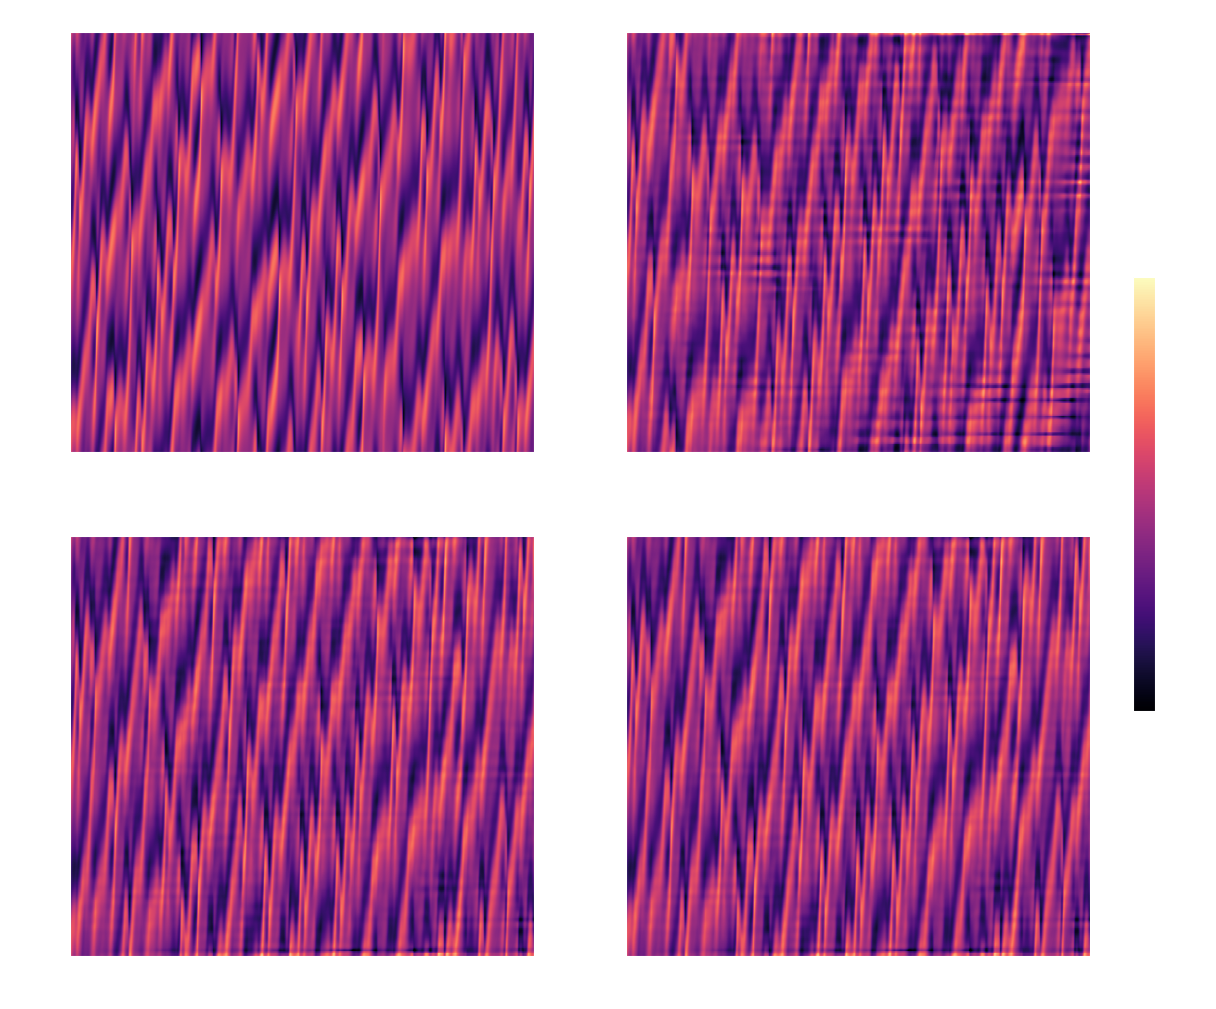

In [42]:
vmin = torch.min(torch.stack([u_test, pred_1])).item()
vmax = torch.max(torch.stack([u_test, pred_1])).item()


fig, axs = plt.subplots(2, 2, figsize=(14,12), )
axs[0,0].imshow(u_test.T, aspect='auto', origin='lower', cmap='magma', vmin=vmin, vmax=vmax)
axs[0,0].set_title("True u(x,t)")
axs[0,0].set_xlabel("Time step")
axs[0,0].set_ylabel("Spatial index")

axs[0][1].imshow(pred_1.T, aspect='auto', origin='lower', cmap='magma', vmin=vmin, vmax=vmax)
axs[0][1].set_title("Model 1Predicted u(x,t)")
axs[0][1].set_xlabel("Time step")
axs[0][1].set_ylabel("Spatial index")

axs[1][0].imshow(pred_2.T, aspect='auto', origin='lower', cmap='magma', vmin=vmin, vmax=vmax)
axs[1][0].set_title("Model 2 Predicted u(x,t)")
axs[1][0].set_xlabel("Time step")
axs[1][0].set_ylabel("Spatial index")

axs[1][1].imshow(pred_2.T, aspect='auto', origin='lower', cmap='magma', vmin=vmin, vmax=vmax)
axs[1][1].set_title("Model 3 Predicted u(x,t)")
axs[1][1].set_xlabel("Time step")
axs[1][1].set_ylabel("Spatial index")

# Choose how many ticks to show (e.g., 5 evenly spaced ticks)
xtick_locs = np.linspace(0, len(t) - 1, 6, dtype=int)
xtick_labels = [f"{t[i]:.0f}" for i in xtick_locs]

# Space ticks (vertical axis, index 0 to 255)
ytick_locs = np.linspace(0, len(x) - 1, 6, dtype=int)
ytick_labels = [f"{x[i]:.1f}" for i in ytick_locs]

for i in range(2):
    for j in range(2):
        ax = axs[i][j]
        ax.set_xticks(xtick_locs)
        ax.set_xticklabels(xtick_labels)
        ax.set_yticks(ytick_locs)
        ax.set_yticklabels(ytick_labels)

cbar = fig.colorbar(axs[0,0].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label("u value", rotation=270, labelpad=15)
plt.style.use('dark_background')
fig.patch.set_facecolor('None')
fig.set_facecolor('None')

for ax in axs.flat:
    ax.set_facecolor('None')
plt.savefig("Multi_Resolution_Heat_Map.png")
plt.show()

In [29]:
dx_val = 22 / 1024

u_test = (u_test - u_test.mean()) / u_test.std()
pred_1 = (pred_1 - pred_1.mean()) / pred_1.std()
pred_2 = (pred_2 - pred_2.mean()) / pred_2.std()
pred_3 = (pred_3 - pred_3.mean()) / pred_3.std()

# Numerical derivatives
u_x = (u_test[:, 2:] - u_test[:, :-2]) / (2 * dx_val)
u_xx = (u_test[:, 2:] + u_test[:, :-2] - 2 * u_test[:, 1:-1]) / (dx_val ** 2)
pred_x_1= (pred_1[:, 2:] - pred_1[:, :-2]) / (2 * dx_val)
pred_xx_1 = (pred_1[:, 2:] + pred_1[:, :-2] - 2 * pred_1[:, 1:-1]) / (dx_val ** 2)
pred_x_2 = (pred_2[:, 2:] - pred_2[:, :-2]) / (2 * dx_val)
pred_xx_2 = (pred_2[:, 2:] + pred_2[:, :-2] - 2 * pred_2[:, 1:-1]) / (dx_val ** 2)
pred_x_3 = (pred_3[:, 2:] - pred_3[:, :-2]) / (2 * dx_val)
pred_xx_3 = (pred_3[:, 2:] + pred_3[:, :-2] - 2 * pred_3[:, 1:-1]) / (dx_val ** 2)

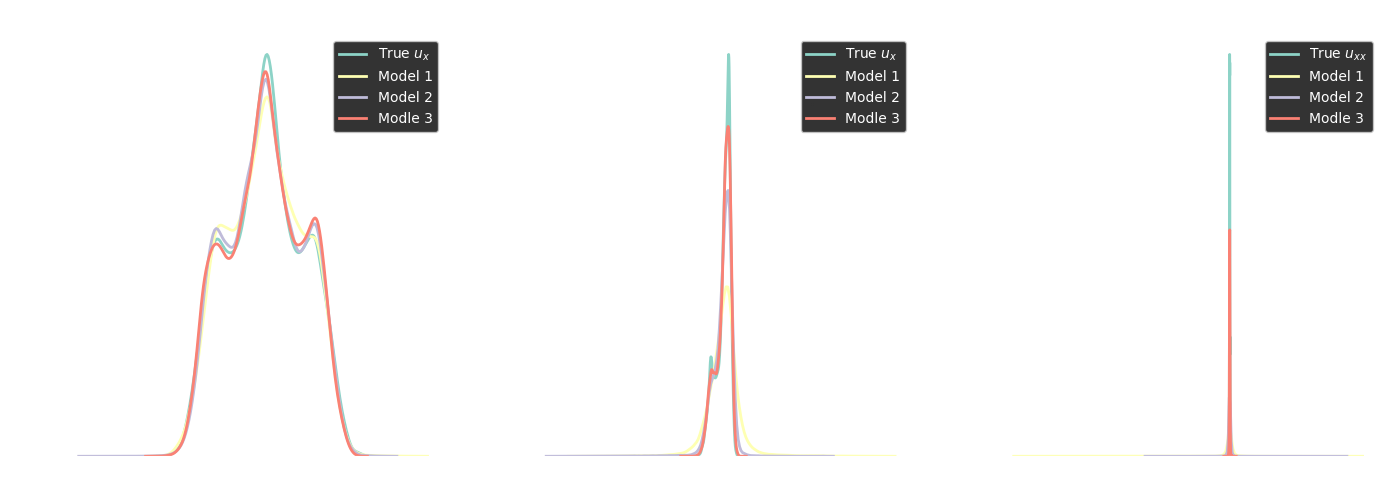

In [43]:
fig, axs = plt.subplots(1,3,figsize=(14,5))
plt.subplot(1, 3, 1)
sns.kdeplot(u_test.reshape(-1).numpy(), label="True $u_x$", linewidth=2)
sns.kdeplot(pred_1.reshape(-1).numpy(), label="Model 1", linewidth=2)
sns.kdeplot(pred_2.reshape(-1).numpy(), label="Model 2", linewidth=2)
sns.kdeplot(pred_3.reshape(-1).numpy(), label="Modle 3", linewidth=2)
plt.title("PDF of $u$")
plt.grid()
plt.legend()

plt.subplot(1, 3, 2)
sns.kdeplot(u_x.reshape(-1).numpy(), label="True $u_{x}$", linewidth=2)
sns.kdeplot(pred_x_1.reshape(-1).numpy(), label="Model 1", linewidth=2)
sns.kdeplot(pred_x_2.reshape(-1).numpy(), label="Model 2", linewidth=2)
sns.kdeplot(pred_x_3.reshape(-1).numpy(), label="Modle 3", linewidth=2)
plt.title("PDF of $u_{xx}$")
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
sns.kdeplot(u_xx.reshape(-1).numpy(), label="True $u_{xx}$", linewidth=2)
sns.kdeplot(pred_xx_1.reshape(-1).numpy(), label="Model 1", linewidth=2)
sns.kdeplot(pred_xx_2.reshape(-1).numpy(), label="Model 2", linewidth=2)
sns.kdeplot(pred_xx_3.reshape(-1).numpy(), label="Modle 3", linewidth=2)
plt.title("PDF of $u_{xx}$")
plt.legend()
plt.tight_layout()
plt.grid()

plt.style.use('dark_background')
fig.patch.set_facecolor('none')
fig.set_facecolor('None')
for ax in axs.flat:
    ax.set_facecolor('none')
    
plt.savefig("PDFs_KSE.png")
plt.show()